<a href="https://colab.research.google.com/github/claudia-viaro/optimal_stopping-switching/blob/main/optimal_switching_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats

import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata

#Problem Formulation
Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options). Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t^i = (b-\delta_i)dt + \sigma_i dW_t^i
\end{equation}
where $W$ is a standard Brownian otion on a filtered probability space $(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \geq 0}, \mathbb{P})$ and $b$, $d_i$, $\sigma_i >0$ are the drift, dividend yield and volatility of the system at time $t$.

We will consider a discrete time approximization (Euler schema) on an equidistant time grid $0=t_0 < t_1 < \ldots < t_N = T$, where $t_n = n \cdot T/N$. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
x^p_{n,i} = x_{0,i} \cdot \exp \Big\{ \sum_{k=0}^n \big( (b-\delta_i - \sigma^2_i /2)\Delta t + \sigma_{i} \sqrt{\Delta t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\Delta t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.

In [ ]:
''' 
underlying process - Geometric brownian motion

both functions here are equivalent

'''





class BlackScholes:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths, self.assets ))

    spot_paths[0, :, :] = self.spot
    random_numbers = np.random.normal(
        0, 1, (self.periods, paths, self.assets ))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), self.periods, axis=0),
        paths, axis=1), self.assets, axis=2)
    sig = np.ones((self.periods, paths, self.assets))*self.sigma
    #sig = np.repeat(np.repeat(np.repeat(
    #    np.reshape(self.sigma, (-1, 1, 1)), self.periods+1, axis=2),
    #    paths, axis=1), self.assets, axis=0)
    
    spot_paths[1:, :,  :] = np.repeat(
        spot_paths[0:1, :, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])



class GBM:
    def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike = 100,dividend=0):
        self.maturity = maturity
        self.strike = strike
        self.assets = assets
        self.sigma=sigma *np.ones(self.assets)
        self.delta=delta
        self.spot = spot*np.ones(self.assets)
        self.drift = drift - dividend
        self.paths = paths
        self.periods = periods
        self.dt = self.maturity / self.periods
    
    def simulate_process(self):
        
        dt = self.maturity / self.periods
        So_vec=self.spot*np.ones((1,S.paths, S.assets))
        
        Z=np.random.standard_normal((self.periods,self.paths, self.assets))
        s=self.spot*np.exp(np.cumsum((self.drift-self.delta-0.5*self.sigma**2)*dt+self.sigma*np.sqrt(dt)*Z, axis=0))
        
        s=np.append(So_vec, s, axis=0)
        return s  
    

In [ ]:
'''
PLOT
'''

def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

(10, 5000, 2)


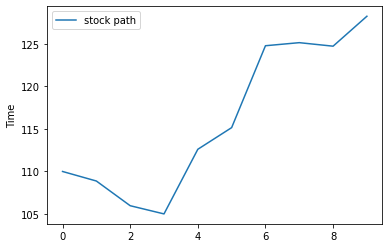

In [ ]:
'''
set the parameters of the process 
'''

hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':5000, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':2,  'spot':110,}

'''
generate paths
'''

#S = GBM(**hyperparam_test_stock_models)
#X=S.simulate_process()
S=BlackScholes(**hyperparam_test_stock_models)
X=S.simulate_process()

'''
generate paths
'''

print(X.shape) # (date, path, asset)
draw_stock_model(X) 

# Switching regime

The stochastic system can operate in $m$ modes or regimes from the finite set $\mathbb{I}=\{1, \ldots , q \}$. In this case we consider $q=2$ with $\mathbb{I}=\{\text{on}, \text{off} \}$. 

The regimes can be switched at a sequence of stopping times over a finite horizon $[0, \ldots , T]$.

There is a payoff rate per unit of time when the system is in mode $i \in \mathbb{I}$ at time $t$ as a mapping $\Psi_i(t, X_t): \Omega \times [0, T] \rightarrow \mathbb{R}$. The payoff function for the call option used is of the form $( \max_{i \in \{ 1, \ldots , d \}} X_t^i - K) ^{+}$, where $K$ is the strike price at any point in the time grid $0 = t_0 < t_1 < \ldots < t_N = T$. the system also outputs a final reward for being in mode $i \in \mathbb{I}$ at time $T$ given by $\Gamma_i$.

There is a cost for switching from regime $i$ to $j$ given by the function $\gamma_{i, j} : \Omega \times [0, T] \rightarrow \mathbb{R} $ to cover for the extra costs due to the change of the regime.

A strategy $\alpha$ for the power plant will be a combination of two sequences:
- non decreasing sequence of $\mathbb{F}$-stopping times $(\tau_n)_{n \geq 1}$, $n \in \mathbb{N} \backslash \{0\}$, where at $\tau_n$ the production is swithced from the current mode $i$ to $j$. we also assume: $\tau_0=t$ and $\tau_n \leq \tau_{n+1}$.
- a sequence of indicators $(\iota)_{n \geq 1}$, $n \in \mathbb{N} \backslash \{0\}$, $\mathcal{F}_{\tau_n}$- measurable valued in $\mathbb{I}_q$. At time $t=\tau_n$ the system is switched from the current regime $\iota_{n-1}$ to $\iota_{n}$, with $\iota_{0}=i$.

We denote by $\mathcal{A}_{t, i}$ the set of admissible strategies to switch at time $\tau_n$, $n \geq 1$, from the current regime $\iota_{n-1}$ to $\iota_{n}$. 


# Neuarl Network




In [ ]:
class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.layer1 = nn.Linear(assets, H)
    self.leakyReLU = nn.LeakyReLU(0.5)
    self.Softplus = nn.Softplus()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.layer2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.layer3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)

  def forward(self, x):
    x = self.bn0(x)
    x = self.layer1(x)
    x = self.relu(x)
    x = self.bn2(x)
    x = self.layer3(x)
    x = self.sigmoid(x)
    return x



'''
class Ftheta_NN(nn.Module):
  def __init__(self, assets, hidden_size):
    super(Ftheta_NN, self).__init__()
    self.l1 = nn.Linear(assets, hidden_size) 
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, 1)  
    self.sigmoid=nn.Sigmoid()
    
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    out = self.sigmoid(out)
    return out
'''
# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

# Class "Profit"
This class contains various payoff and costs elements that define the reward. The final profit value is computed for each date and path.

### terminal reward
The terminal function $\Gamma$ is set to an option payoff function of choice regardless of the regime in which the process is at, in this case we have a Max Call. (other choices can be made as well). The terminal payoff is received at maturity, with no other costs nor payoffs.
\begin{equation}
\Gamma(n) = \Big(\max_{i \in \{1, \ldots, d \}} x^i - K   \Big)^{+} \tag{1}
\end{equation}

### running reward
The function $\Psi_q = (\Psi_q(n))_{n \in \mathbb{N}}$ represents the running reward received while in mode $q \in \mathbb{I}$. 
\begin{equation}
\Psi_q(n) = \Big[\Big(\max_{i \in \{1, \ldots, d\}} x^i_n - K   \Big)^{+} \Big]^{k_q} \;\;\;\;\; k \in \{.4, .7 \} \tag{2}
\end{equation}

### switching cost
The function $\gamma_{i, j} = (\gamma_{i, j}(n))_{n \in \mathbb{N}}$ with $i,j \in \mathbb{I} = \{0, 1 \}$ represents the cost for switching from mode $i \in \mathbb{I}$ to mode $j \in \mathbb{I}$.
\begin{equation} \tag{3}
\gamma_{0,0} \equiv \gamma_{1,1} \equiv 0 \\
\gamma_{0,1}(n) = \Big(\max_{i \in \{1, \ldots, d \}} x^i - K   \Big)^{+} + \delta  \;\;\;\;\; \delta = .7   \\ 
\gamma_{1, 0}(n) = \Big(\max_{i \in \{1, \ldots, d \}} x^i - K   \Big)^{+} 
\end{equation}

### the full expression for the profit
The entire expression for the value of the process at each time $n$ can be represented as: 
\begin{equation} \tag{4}
\check{Y}_{N}^i = \Gamma \\
\check{Y}_{n}^i = \Psi_i(n) + \max_{j \in \{0, 1 \}} 
\{- \gamma_{i, j}(n) + e^{-\rho h} \check{Y}_{n+1}^j   \} \;\;\;\;\;\;\;\;\;\; \text{for } n=N-1, \ldots, 0
\end{equation}


### Note
There are actually two profit classes:
- Profit_training (actually only the function "running") is used to compute $(\check{Y}_{n}^i, \check{Y}_{n}^j)$ at each date which is needed to in the loss function for the optimization of the parameters. As the optimization of the parameters will tell about switching/not I have to assume the profit can occur under both regimes [which is not fully correct then]
- Profit_testing (function "running") is used to compute $(\check{Y}_{n}^i), i \in \mathbb{I}$, once the new regime of the system is known  


In [ ]:
class Profit_training:
  def __init__(self, model):
    self.strike = model.strike

  def terminal(self, X):
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)

  def g(self, date,path,X):
    X=torch.from_numpy(X).float()
    max1=torch.max(X[int(date) , path , : ].float()-S.strike)
    return np.exp(-S.drift*S.dt*date)*torch.max(max1,torch.tensor([0.0])) 
 

  def running(self, Y, X):
    gamma = np.array([-self.terminal(X), self.terminal(X) + 0.7]) # there are two rows, the first for \gamma_{0,1}, the second for \gamma_{1,0}
    r_benefit = self.terminal(X)
    return torch.from_numpy(r_benefit+Y-gamma)  
 
class Profit_testing:
  def __init__(self, model):
    self.strike = model.strike

  def terminal(self, X):
    terminal = np.max(X, axis=1) - self.strike
    return terminal.clip(0, None)

  def g(self, date,path,X):
    X=torch.from_numpy(X).float()
    max1=torch.max(X[int(date) , path , : ].float()-S.strike)
    return np.exp(-S.drift*S.dt*date)*torch.max(max1,torch.tensor([0.0])) 


  # switch is F_theta_train 
  def running(self, Y, date, path, S, X, switch, gamma):
    val=Y[date+1, path]- gamma  
    k = np.array([0.4, 0.7])
    r_benefit = self.g(date, path, X)
    return val*int(switch[date, path])+r_benefit.numpy()

# Class "OptimizationPart"
This class contains the building blocks necessary to train the neural network which allows to perform a gradient ascent optimization algorithm on the parameters $\theta_n$, thus approximating the stopping times $\tau_{n+1}$.
The main components of this class are:

### 1) train_network (the loss function) 

In order to use the Back Propagation algorithm from Pytorch, the maximization task is transformed into minimizing the negative of the objective function.

\begin{equation}
L = -\frac{1}{M} \sum_{m=1}^M r_n^m (\theta_n) \tag{5}
\end{equation}

where we specify the reward function as being
\begin{equation}
r_n^m (\theta_n) = g(n, x_n^m)F^{\theta}(x_n^m)+ g(\bar{\tau}_{n+1}^m, x_{\bar{\tau}_{n+1}^m}^m)(1-F^{\theta}(x_n^m) ) \tag{6}
\end{equation}
where the $g()$ function is $(3)$.

### *To recap*
At time $n$ along path $m$, the reward is equal to $(2)$ taking into account the possible events of switching or not regime with probability given by $F^{\theta_n}$.

For a large number of paths $M$, we can say that $(1)$ approximates $\mathbb{E}[g(n, X_n)f^{\theta}(X_n)+ g(\tau_{n+1}, X_{\tau_{n+1}})(1-f^{\theta}(X_n) ) ]$. This is the function we optimize using gradient descent algorithm with respect to $\theta_n$. The algorithm outputs the probability values of switching $F^{\theta_n}$ for each date and for all paths considered, which we then translate into $0-1$ switching decisions $f^{\theta_n}$.

For each epoch, we use the set $\theta_n$ from the previous epoch (where the very first set is initialized according to a uniform distribution) to compute $F^{\theta_n}$. Then the updated ("loss.step()") $\theta_n$ are obtained via backpropagation by the gradient of the loss function ("loss.backward()"). 


### 2) evaluate_network
After training, the algorithm proceeds with the evaluation phase where it outputs the probability values of switching $F^{\theta_n}$. These corresponds to the object "stopping_probability".

In [ ]:
class OptimizationPart(object):

  def __init__(self, assets, paths, epochs=50, batch_size=2000):
    self.assets = assets
    self.paths = paths
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = Ftheta_NN(self.assets).double()
    self.network.apply(init_weights)


  def train_network(self,  stock_values, current_payoff,
                    future_payoff):
    optimizer = optim.Adam(self.network.parameters())
    #future_payoff = torch.from_numpy(future_payoff).double()
    #current_payoff = torch.from_numpy(current_payoff).double()
    X_inputs = torch.from_numpy(stock_values).double()

    self.network.train(True)
    ones = torch.ones(self.paths)
    for epoch in range(self.epochs):
      optimizer.zero_grad()
      outputs = self.network(X_inputs).reshape(-1) # probabilities
      reward = (current_payoff * outputs ) +future_payoff * (ones - outputs) # reward function
      loss = -torch.mean(reward) # loss function
      loss.backward() # gradient calculation of the loss function
      optimizer.step() # gradient descent update

  def evaluate_network(self, X_inputs):
    self.network.train(False)
    X_inputs = torch.from_numpy(X_inputs).double()
    outputs = self.network(X_inputs)
    return outputs.view(X_inputs.size()[0]).detach().numpy()
   

# Class "Recursion"
This class contains the main calculations of the algorithm, hence the recursion.

### price
First we start with some elements:
1. we simulate $d$ asset prices $\{X^i \}^d_{i=1}$ along $m$ paths according to a geometric Brownian motion process. We consider the iys discretized version on an equidistant time grid, $t_n = n \cdot T/N$ for $n=0, \ldots, N$:
\begin{equation} \tag{7}
x_{n,i}^m = x_{0,i} \cdot \exp \Big\{\sum_{k=0}^n \Big((r-\delta_i - \sigma_i^2 /2) \Delta t + \sigma_i \sqrt{\Delta t} \cdot Z_{k, i}^m  \Big) \Big\}
\end{equation}
where $(r-\delta_i) \in \mathbb{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$, $\Delta t =T/N$ and $Z_{k, i}^m \sim \mathcal{N}(0,1)$

2. we define the discount factor $\exp \{(r-\delta_i )\Delta t \}$
3. we create the "regime" object $\mathbb{I} = \{0, 1 \}$
4. we create the empty objects: "regime_path" that records the regime in which the process is at for every time step and path; "Y_train" that records the profit value for each time step and path; "F_theta_train" that records the presence of a stopping time


Then we can start the recursion:

*At maturity $N$*
1. we sample a regime to specify in which regime the process is and record it in "regime_path". The sampled regime is the same across all paths
2. we compute the profit at $N$ "final_payoff" $\check{Y}_{N}^i$ according to $(4)$ and record it in "Y_train"

*Before maturity, for each date $ n=N-1, \ldots, 0$*
1. we compute "current_payoff" using "Profit_training.running()"
2. we obtain a stopping rule for each path, using as arguments the current payoff, the discounted final payoff (now called "values") and the entire process. Record then the stopping rules in "F_theta_train" **[I am not sure about the discounting]**
3. we determine the current regime on the basis of the regime from the previous time step and if there has been or not a stopping time. Hence if at $n$ we have $F_n^{\theta}=1$ and $q_{n+1} = i$, we choose $q_n=j$. We then record this in "regime_path"
4. we compute $\check{Y}_{n}^i$ according to $(4)$, using "Profit_training.running()" appropriate for its current regime and record it under "Y_train". Hence we have a matrix with dimension periods x paths, recording $\check{Y}_{n}^i$
5. we compute the mean estimate across paths for each date (Y_test_mean) and the standard error so that we can plot the values with a 95% CI


In [ ]:
class Recursion:
  def __init__(self, model, training, testing, nb_epochs=50):

    self.model = model # argument is S    
    self.neural_stopping = OptimizationPart(model.assets, model.paths) 
    self.profit_training = Profit_training(self.model)
    self.profit_testing = Profit_testing(self.model)

  def price(self):
    model = self.model
    stock_paths = self.model.simulate_process()    
    disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    
    # create empty objects to store values
    k = np.array([0.4, 0.7])
    regimes = [0, 1]
    regime_path=np.zeros((model.periods+1, model.paths)) # record at which regime we're at at each n
    Y_train=np.zeros((model.periods+1, model.paths))
    F_theta_train=np.zeros((model.periods+1,model.paths)) # record switching events for each n

    # at maturity N
    final_payoff = np.array([self.profit_training.terminal(stock_paths[-1, :, :]), self.profit_training.terminal(stock_paths[-1, :, :])])   # payoff of the last date for each path.
    future_payoff = torch.from_numpy(final_payoff*disc_factor).double() 
    Y_train[model.periods, :]= final_payoff[0]
    F_theta_train[model.periods,:]=1 # at maturity we switch (does it matter?)
    regime_path[model.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
    values = Y_train[model.periods, :]
    print("date", model.periods, ":", 1," , ", 1, " , ", model.paths)

    # recursive calc. before maturity
    for date in range(stock_paths.shape[0] - 2, 0, -1): 
      current_payoff = self.profit_training.running(Y_train[date+1, :], stock_paths[date, :, :])

      stopping_probability = self.stop(stock_paths[date, : , :], 
                                current_payoff,
                                future_payoff)
      
      print("date", date, ":", round(np.min(stopping_probability),3)," , ", round(np.max(stopping_probability),3), " , ", len([1 for l in stopping_probability if l > 0.5])) # print the min/max stopping probabilities and the count of stopping times for each date
      F_theta_train[date,:]=(stopping_probability > 0.5)*1.0   # transform stopping probabilities in 0-1 decision
      which = stopping_probability > 0.5

      for m in range(0,model.paths-1):
        old_regime = regime_path[date +1, m]
        if  which[m] == True :
          regime_path[date , m] = regimes[~int(old_regime)] 
          gamma = self.profit_testing.g(date, m, X) + 0.7
        else:
          regime_path[date , m] = old_regime
          gamma = -self.profit_testing.g(date, m, X)
        Y_train[date, m] = self.profit_testing.running(Y = Y_train, date = date, 
                                                path = m, S=model, 
                                                X = stock_paths,  switch = F_theta_train, 
                                                gamma = gamma)
      immediate_exercise_value = Y_train[date, :]       
      values[which] = immediate_exercise_value[which] # when we switch we take the current profit
      values[~which] *= disc_factor           # when we don't switch we take final profit discounted 
      Y_train[date, :] = values


    payoff_0 = Y_train[0, :]
    return round(max(payoff_0[0], np.mean(values)) * disc_factor,3), payoff_0, Y_train 



  def stop(self, stock_values, current_payoff,
           future_payoff):
    
    self.neural_stopping.train_network(
      stock_values,
      current_payoff ,
      future_payoff)

    inputs = stock_values
    stopping_probability = self.neural_stopping.evaluate_network(inputs)
    return stopping_probability    

In [ ]:
t_begin = time.time()

pricing = Recursion(S, Profit_training, Profit_testing, nb_epochs=50)
'''
arguments are:
- path process
- Profit training and profit testing classes
- number of epochs to be used for the gradient descent algorithm

'''
duration = time.time() - t_begin
output, payoff_0, values = pricing.price()

print(round(duration, 3))

'''
here we are printing:
- date
- min and max probability of switching across the 5000 paths
- number paths that will switch for each date

'''

date 9 : 1  ,  1  ,  5000
8 : 9.153968329118165e-06  ,  0.9522900785963158  ,  3832
7 : 4.4716234911242014e-11  ,  0.9930842450265744  ,  4091
6 : 2.35941609686681e-19  ,  0.9944858998330752  ,  4559
5 : 3.2356072608001305e-37  ,  0.9989254859378646  ,  4771
4 : 4.1785701648906726e-60  ,  0.9996030062723464  ,  4911
3 : 1.5689476799351864e-63  ,  0.9999872521455605  ,  4786
2 : 2.3104497208329197e-65  ,  0.9999999144240876  ,  4478
1 : 6.8170872018228175e-68  ,  0.9999999995815247  ,  4506
0.013


'\nhere we are printing:\n- date\n- min and max probability of switching across the 5000 paths\n- number paths that will switch for each date\n\n'

In [ ]:
print(output, payoff_0)
print(len(values))

50.35 [0. 0. 0. ... 0. 0. 0.]
10


In [ ]:
'''
produce table with estimated values for different spot prices and state dimension (d)
'''


dict ={}
 
# Insert data into dictionary
dict1 = {
     1: ["2", 90, 26.116, 0.008],
     2: ["2", 100, 38.914, 0.007],
     3: ["2", 110, 50.35 , 0.013],
     4: ["3", 90, 27.261, 0.009],
     5: ["3", 100, 40.255, 0.01],
     6: ["3", 110, 51.849, 0.007],
     7: ["4", 90, 26.365 , 0.005],
     8: ["4", 100, 38.953, 0.008],
     9: ["4", 110, 51.501, 0.009],
     10: ["5", 90, 28.973, 0.005],
     11: ["5", 100, 40.239, 0.007],
     12: ["5", 110, 53.313, 0.008],
     13: ["10", 90, 30.754, 0.008],
     14: ["10", 100, 44.809, 0.007],
     15: ["10", 110, 58.627, 0.01],
     16: ["20", 90, 33.514, 0.012],
     17: ["20", 100, 48.429, 0.011],
     18: ["20", 110, 62.239,0.011],
     }
 
# Print the names of the columns.
print ("{:<10} {:<10} {:<10} {:<10}".format('assets', 'spot', 'L', 'timeL'))
 
# print each data item.
for key, value in dict1.items():
    assets, spot, L, timeL = value
    print ("{:<10} {:<10} {:<10} {:<10}".format(assets, spot, L, timeL))


import pandas as pd
pricing_df = pd.DataFrame.from_dict(dict1, orient='index')
pricing_df.columns = ['assets', 'spot', 'L', 'timeL']
pricing_df    

assets     spot       L          timeL     
2          90         26.116     0.008     
2          100        38.914     0.007     
2          110        50.35      0.013     
3          90         27.261     0.009     
3          100        40.255     0.01      
3          110        51.849     0.007     
4          90         26.365     0.005     
4          100        38.953     0.008     
4          110        51.501     0.009     
5          90         28.973     0.005     
5          100        40.239     0.007     
5          110        53.313     0.008     
10         90         30.754     0.008     
10         100        44.809     0.007     
10         110        58.627     0.01      
20         90         33.514     0.012     
20         100        48.429     0.011     
20         110        62.239     0.011     


,assets,spot,L,timeL
1,2,90,26.116,0.008
2,2,100,38.914,0.007
3,2,110,50.350,0.013
4,3,90,27.261,0.009
5,3,100,40.255,0.010
6,3,110,51.849,0.007
7,4,90,26.365,0.005
8,4,100,38.953,0.008
9,4,110,51.501,0.009
10,5,90,28.973,0.005


In [ ]:
'''
in case I need to check steps
'''




'''

model = S # argument is S    
profit_training = Profit_training(model) #class profit. the argument is Profit, then you can call profit.terminal, etc
epochs = 50
stock_paths = model.GBM()    
disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))

k = np.array([0.4, 0.7])
regimes = [0, 1]
regime_path=np.zeros((S.periods+1, S.paths)) # record at which regime we're at at each n
Y_train=np.zeros((S.periods+1, S.paths))
F_theta_train=np.zeros((S.periods+1,S.paths)) # record switching events for each n

# at maturity N
final_payoff = np.array([profit_training.terminal(stock_paths[-1, :, :]), profit_training.terminal(stock_paths[-1, :, :])])   # payoff of the last date for each path. 
Y_train[S.periods, :]= final_payoff[0]

F_theta_train[S.periods,:]=1 # at maturity we switch (does it matter?)
regime_path[S.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity
neural_stopping = OptimizationPart(model.assets, model.paths) 

    


date = stock_paths.shape[0]-2
current_payoff =  profit_training.running(Y_train[date+1, :], stock_paths[date, :, :])

network = Ftheta_NN(model.assets).double()
network.apply(init_weights)
optimizer = optim.Adam(network.parameters())
print(type(final_payoff))
future_payoff = torch.from_numpy(final_payoff*disc_factor).double()
X_inputs = torch.from_numpy(stock_paths[date, :, :]).double()
print("final", torch.from_numpy(final_payoff).double())
print("current", current_payoff.size(),current_payoff)
print("X_inopts", X_inputs)
print("values", final_payoff)
print("future", future_payoff.size(), future_payoff)
print(network(X_inputs))
network.train(True)
ones = torch.ones(S.paths)


for epoch in range(epochs):
  optimizer.zero_grad()
  outputs = network(X_inputs).reshape(-1) # probabilities
  reward = (current_payoff * outputs +
              future_payoff * (ones - outputs)) # reward function
  print(len(outputs) ,type(outputs), len(current_payoff), len(future_payoff))            
  loss = -torch.mean(reward) # loss function
  loss.backward() # gradient calculation of the loss function
  optimizer.step() # gradient descent update


network.train(False)
X_inputs = torch.from_numpy(stock_paths[date, :, :]).double()
outputs = network(X_inputs)
stopping_probablities =outputs.view(X_inputs.size()[0]).detach().numpy()
print(stopping_probablities)

print(date, ":", np.min(stopping_probablities)," , ", np.max(stopping_probablities), " , ", len([1 for l in stopping_probablities if l > 0.5]))
F_theta_train[date,:]=(stopping_probablities > 0.5)*1.0   
which = stopping_probablities > 0.5
print(len(stopping_probablities), model.paths)
profit_testing = Profit_testing(model)
print(which)
for m in range(0, model.paths):
         old_regime = regime_path[date +1, m]
         if  which[m] == True :
           regime_path[date , m] = regimes[~int(old_regime)] 
           gamma = profit_testing.g(date, m, stock_paths) + 0.7
         else:
           regime_path[date , m] = old_regime
           gamma = -profit_testing.g(date, m, X)
         Y_train[date, m] = profit_testing.running(Y = Y_train, date = date, 
                                                path = m, S=model, 
                                                X = stock_paths,  switch = F_theta_train, 
                                                gamma = gamma)
values = Y_train[S.periods, :]
immediate_exercise_value = Y_train[date, :]       
values[which] = immediate_exercise_value[which] # when we switch we take the current profit
values[~which] *= disc_factor           # when we don't switch we take final profit discounted (?)

print("immediate", immediate_exercise_value)
print("values", values)
'''


'\n\nmodel = S # argument is S    \nprofit_training = Profit_training(model) #class profit. the argument is Profit, then you can call profit.terminal, etc\nepochs = 50\nstock_paths = model.GBM()    \ndisc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))\n\nk = np.array([0.4, 0.7])\nregimes = [0, 1]\nregime_path=np.zeros((S.periods+1, S.paths)) # record at which regime we\'re at at each n\nY_train=np.zeros((S.periods+1, S.paths))\nF_theta_train=np.zeros((S.periods+1,S.paths)) # record switching events for each n\n\n# at maturity N\nfinal_payoff = np.array([profit_training.terminal(stock_paths[-1, :, :]), profit_training.terminal(stock_paths[-1, :, :])])   # payoff of the last date for each path. \nY_train[S.periods, :]= final_payoff[0]\n\nF_theta_train[S.periods,:]=1 # at maturity we switch (does it matter?)\nregime_path[S.periods, :] = random.sample(regimes, 1)[0] # sample a regime at maturity\nneural_stopping = OptimizationPart(model.assets, model.paths) \n\n    \